In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# To find the last day:

lastday = list(np.ravel(session.query(Measurement.date).order_by(Measurement.date.desc()).first()))[0]
lastday = lastday.split("-")
year = int(lastday[0])
month = int(lastday[1])
day = int(lastday[2])

# To find 1 year before the last day:

lastyear = dt.date(year, month, day) - dt.timedelta(days=365)
print(f"The last day in the data set is {lastday}")

# Perform a query to retrieve the data and precipitation scores:

precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= lastyear).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(precipitation)
df = df.set_index('date')

# Sort the dataframe by date

df = df.sort_index(ascending=True)
df.head(10)



The last day in the data set is ['2017', '08', '23']


,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


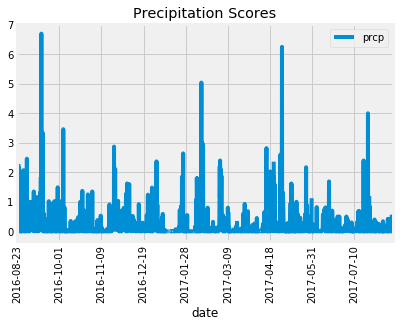

In [9]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90, title='Precipitation Scores')

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
numstations = session.query(Station).count()
print(f"There are {numstations} available stations")

There are 9 available stations


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

activestations = (session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all())
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
mostactiveid = activestations[0][0]
mostactiveid

'USC00519281'

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

lowesttemp = session.query(Measurement.tobs).filter(Measurement.station == mostactiveid).order_by(Measurement.tobs.asc()).first()
highesttemp = session.query(Measurement.tobs).filter(Measurement.station == mostactiveid).order_by(Measurement.tobs.desc()).first()
averagetemp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == mostactiveid).first()
results = [lowesttemp, highesttemp, averagetemp]
results

[(54.0), (85.0), (71.66378066378067)]

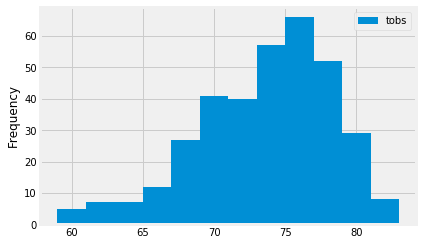

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last12 = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > lastyear).filter(Measurement.station == mostactiveid).order_by(Measurement.date).all())
last12

last12df = pd.DataFrame(last12)
bins = 12
last12df.plot(kind='hist', bins=bins)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

tripstart = '2017-01-03'
tripend = '2017-01-14'

triptemp = calc_temps(tripstart, tripend)
triptemp

[(60.0, 68.35616438356165, 81.0)]

Text(0.5, 1.0, 'Trip Avg Temp')

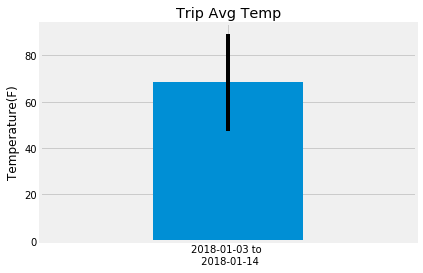

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip = '2018-01-03 to \n 2018-01-14'

mintemp = triptemp[0][0]
avgtemp = triptemp[0][1]
maxtemp = triptemp[0][2]

plt.bar(trip, avgtemp, yerr=maxtemp - mintemp)
plt.xlim(-1, 1)
plt.ylabel('Temperature(F)')
plt.title('Trip Avg Temp')